In [8]:
from dataloader import load_balanced_dataset

In [9]:
data = load_balanced_dataset()

In [10]:
data.head()

,sent_id,text,label
9222,202259-10-05,Denne Sportbacken har derimot vært på dressurk...,2
2668,200247-13-01,Droiden HK - 47 skiller seg ut som den absolut...,2
1181,108739-02-01,I sin tolvte bok på norsk fortsetter Arnaldur ...,2
2528,304814-06-01,Intet nytt 1. desember kommer AC / DC's første...,2
9930,004702-08-01,Don Fabijan ( Kresimir Mikic ) er en ung katol...,2


<AxesSubplot:>

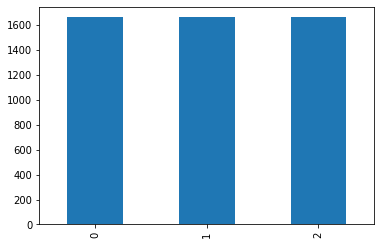

In [11]:
data["label"].value_counts().sort_index().plot.bar()

<AxesSubplot:ylabel='Frequency'>

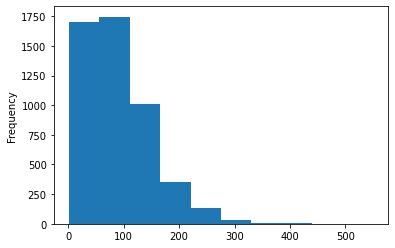

In [12]:
data["text"].str.len().plot.hist()

In [13]:
data["text"] = data["text"].str.lower()
data["text"] = data["text"].str.strip()

In [14]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

tokenizer = Tokenizer(num_words=20000)
tokenizer.fit_on_texts(data["text"].values)

X = tokenizer.texts_to_sequences(data["text"].values)
X = pad_sequences(X)

In [15]:
from keras.models import Sequential
from keras.layers import Dense, LSTM, Embedding, Dropout

model = Sequential()
model.add(Embedding(20000, 128, input_length=X.shape[1]))
model.add(LSTM(128, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(3, activation="softmax"))

In [16]:
model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 89, 128)           2560000   
                                                                 
 lstm (LSTM)                 (None, 128)               131584    
                                                                 
 dense (Dense)               (None, 3)                 387       
                                                                 
Total params: 2,691,971
Trainable params: 2,691,971
Non-trainable params: 0
_________________________________________________________________


In [17]:
import pandas as pd

y = pd.get_dummies(data["label"]).values

In [18]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [19]:
from keras.callbacks import EarlyStopping

early_stop = EarlyStopping(monitor="val_accuracy", mode="max", patience=5)

epochs = 20
batch_size = 16
history = model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, validation_split=0.2, verbose=1,
                    callbacks=[early_stop])

Epoch 1/20
175/175 [==============================] - 38s 197ms/step - loss: 1.0533 - accuracy: 0.4336 - val_loss: 1.0240 - val_accuracy: 0.4821
Epoch 2/20
175/175 [==============================] - 32s 182ms/step - loss: 0.7343 - accuracy: 0.6978 - val_loss: 1.0457 - val_accuracy: 0.5465
Epoch 3/20
175/175 [==============================] - 34s 194ms/step - loss: 0.2375 - accuracy: 0.9223 - val_loss: 1.1772 - val_accuracy: 0.5494
Epoch 4/20
175/175 [==============================] - 34s 195ms/step - loss: 0.0782 - accuracy: 0.9774 - val_loss: 1.5506 - val_accuracy: 0.5393
Epoch 5/20
175/175 [==============================] - 38s 218ms/step - loss: 0.0322 - accuracy: 0.9910 - val_loss: 1.6187 - val_accuracy: 0.5365
Epoch 6/20
175/175 [==============================] - 38s 215ms/step - loss: 0.0183 - accuracy: 0.9953 - val_loss: 1.6573 - val_accuracy: 0.5193
Epoch 7/20
175/175 [==============================] - 39s 223ms/step - loss: 0.0120 - accuracy: 0.9979 - val_loss: 1.9748 - val_ac

In [20]:
from datetime import datetime

model.save(f"models/SA-LSTM-{datetime.now().strftime('%Y%m%d%H%M%S')}.h5")

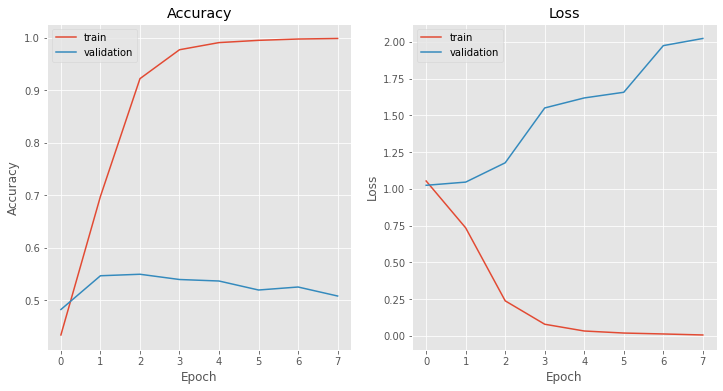

In [21]:
import matplotlib.pyplot as plt

# Plot accuracy and loss in the same figure but in two different plots
plt.style.use("ggplot")
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(history.history["accuracy"], label="train")
plt.plot(history.history["val_accuracy"], label="validation")
plt.title("Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.subplot(1, 2, 2)
plt.plot(history.history["loss"], label="train")
plt.plot(history.history["val_loss"], label="validation")
plt.title("Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()

In [22]:
# Evaluation
val_loss, val_acc = model.evaluate(X_test, y_test)
print("Validation loss:", val_loss)
print("Validation accuracy:", val_acc)

47/47 [==============================] - 2s 35ms/step - loss: 2.0725 - accuracy: 0.5037
Validation loss: 2.0724568367004395
Validation accuracy: 0.5036740303039551
